# Credit Card Fraud Detection Pipeline

This notebook demonstrates a machine learning pipeline for detecting fraudulent credit card transactions. We will preprocess the data, build a model, and evaluate its performance.

## 1. Importing Libraries
First, we import the necessary libraries for data processing, visualization, and model building.

In [27]:
import pandas as pd
import numpy as np
import  seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #for spliting the data 
from sklearn.preprocessing import MaxAbsScaler,QuantileTransformer # for scaling the data
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import classification_report,plot_confusion_matrix
from IPython.display import HTML
HTML("""
<style>
h1,h2,h3 {
	margin: 1em 0 0.5em 0;
	font-weight: 600;
	font-family: 'Titillium Web', sans-serif;
	position: relative;  
	font-size: 36px;
	line-height: 40px;
	padding: 15px 15px 15px 2.5%;
	color: #13003A;
	box-shadow: 
		inset 0 0 0 1px rgba(53,86,129, 1), 
		inset 0 0 5px rgba(53,86,129, 1),
		inset -285px 0 35px white;
	border-radius: 0 10px 0 15px;
	background: #fff
    
}
</style>
""")

## 2. Data Exploration
In this section, we load the dataset and explore its structure to understand what we're working with. This involves viewing a sample of the data and checking its dimensions.

In [28]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [29]:
print('Number of rows are :',data.shape[0], ',and number of columns are :',data.shape[1])

Number of rows are : 284807 ,and number of columns are : 31


### Viewing the Last Few Rows of the Dataset
The `.tail()` function displays the last five rows of the dataset. This is useful for understanding the format and values within the dataset.

In [30]:
data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


### Checking Dataset Shape
The `.shape` attribute returns a tuple representing the dimensions of the dataset. Here, it tells us the number of rows and columns.

In [31]:
data.shape

(284807, 31)

## 3. Target Feature Identification
In this section, we identify the target feature (`Class`) in the dataset, which indicates whether a transaction is fraudulent or not.

In [32]:
data.describe().T.style.bar(subset=["mean"],color="#606ff2").background_gradient(
subset=["std"],cmap="PuBu").background_gradient(subset=["50%"],cmap="PuBu")

,count,mean,std,min,25%,50%,75%,max
Time,284807.000000,94813.859575,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.000000,0.000000,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.000000,0.000000,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.000000,-0.000000,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.000000,0.000000,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.000000,0.000000,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.000000,0.000000,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.000000,-0.000000,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.000000,0.000000,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.000000,-0.000000,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


### Checking null values

In [33]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [34]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [35]:
col=data.columns.to_list()
col

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

## Duplicate Check

In [36]:
data.duplicated().sum()


1081

**There is 1081 duplicate row. let's drop it**

In [37]:
data.drop_duplicates(inplace=True)
print("Shape of data frame : ",data.shape)

Shape of data frame :  (283726, 31)


<AxesSubplot:xlabel='Time', ylabel='Amount'>

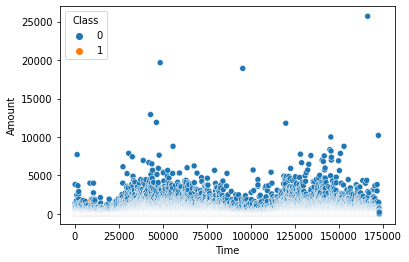

In [38]:
sns.scatterplot(x='Time',y='Amount',hue='Class',data=data)

<AxesSubplot:xlabel='Class', ylabel='count'>

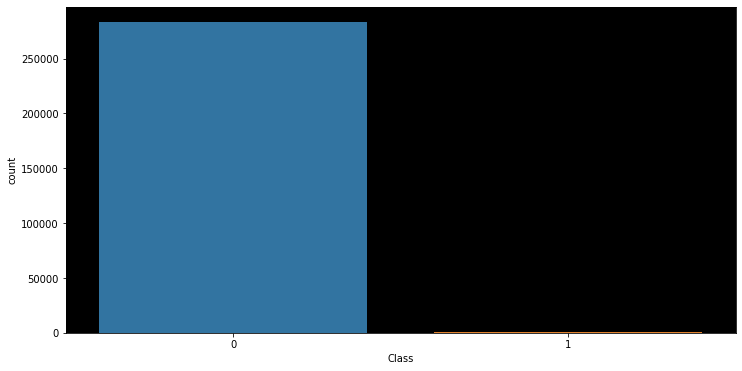

In [39]:
import warnings as wr
wr.filterwarnings("ignore")
plt.figure(figsize=(12,6))
ax=plt.axes()
ax.set_facecolor("black")
sns.countplot(data["Class"])

**here 0 is non fraud and 1 is fraud** 



In [40]:
num_col=['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15',
         'V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount','Class']

### features distribution 

<Figure size 432x288 with 0 Axes>

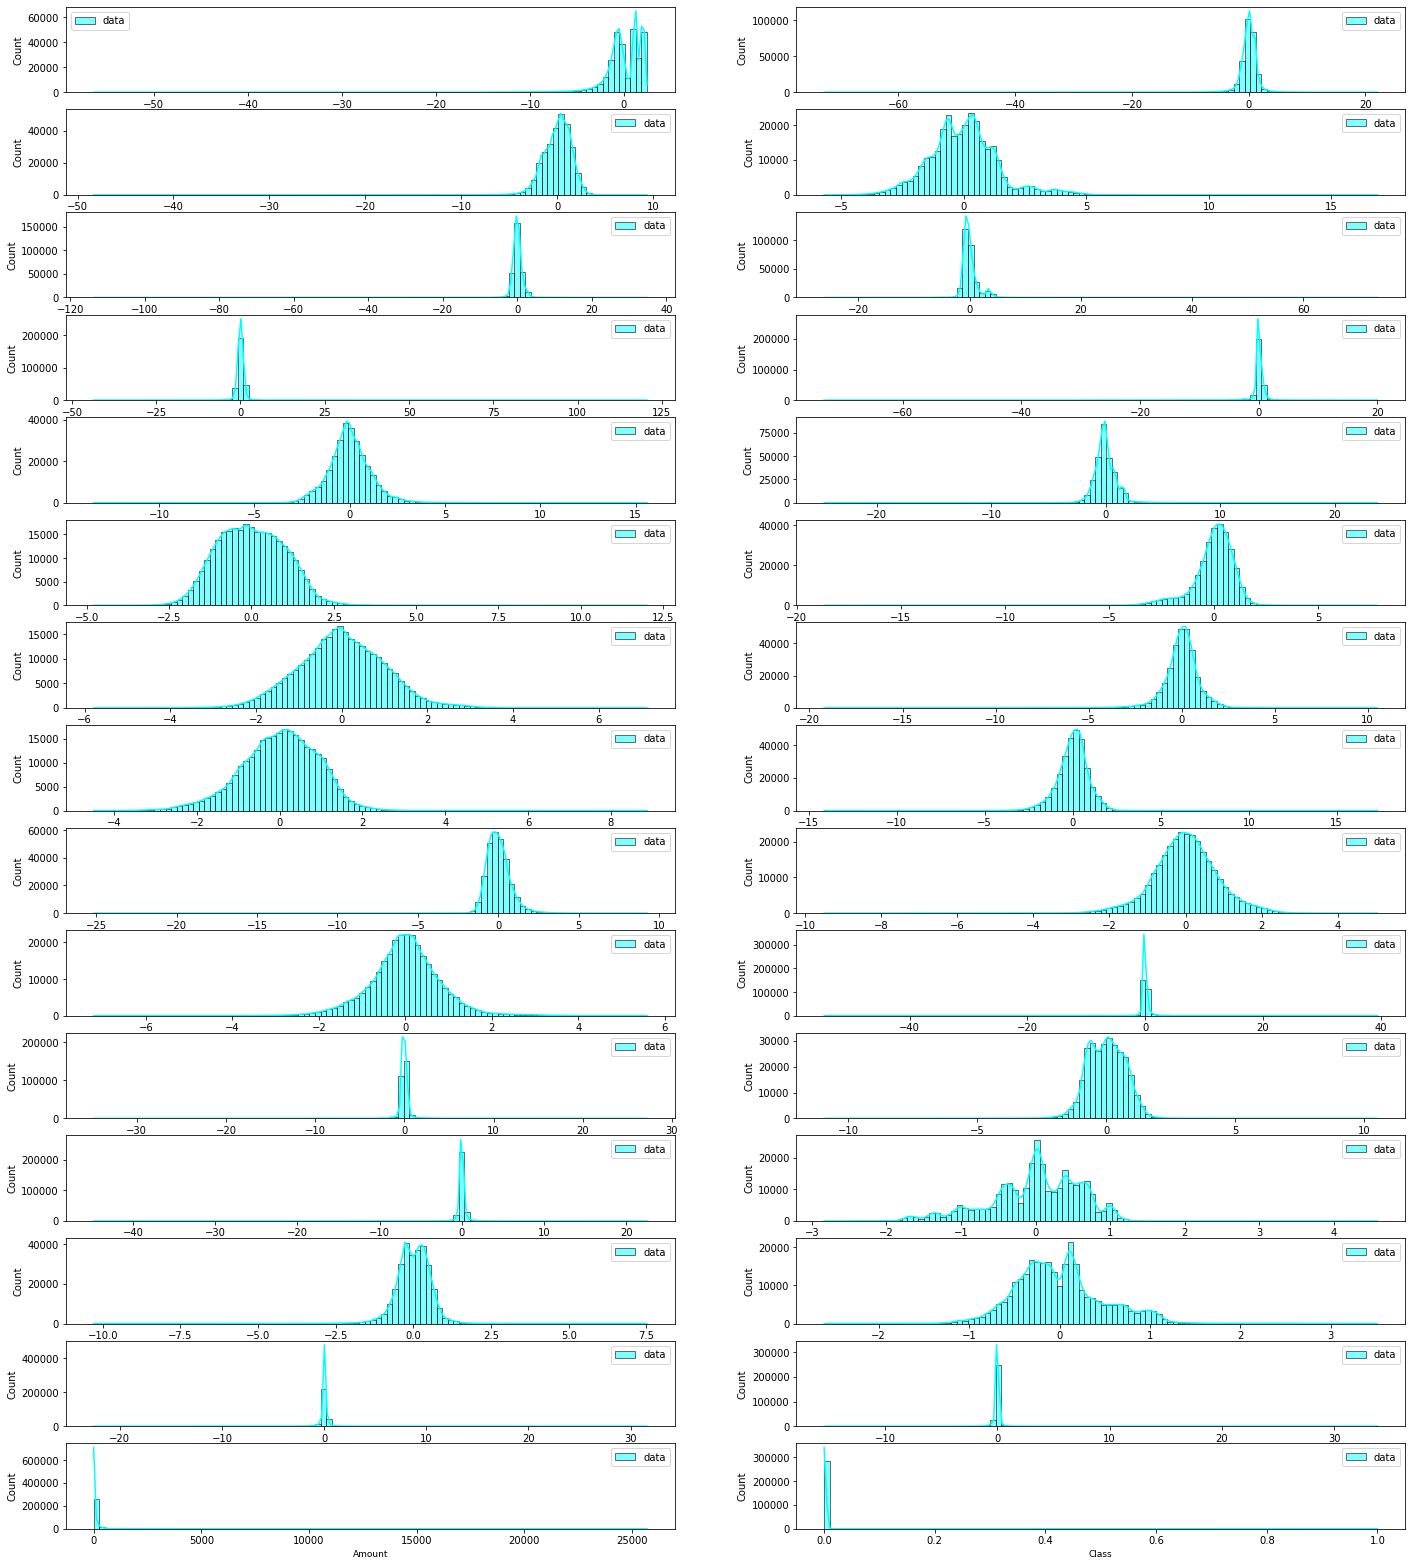

In [41]:
i = 1
plt.figure()
fig, ax = plt.subplots(15, 2,figsize=(24, 28))
for feature in num_col:
    plt.subplot(15, 2,i)
    sns.histplot(data[feature],color="aqua", kde=True,bins=100, label='data')
    plt.xlabel(feature, fontsize=9); plt.legend()
    i += 1
plt.show()

### Feature Scatter Plot

<Figure size 432x288 with 0 Axes>

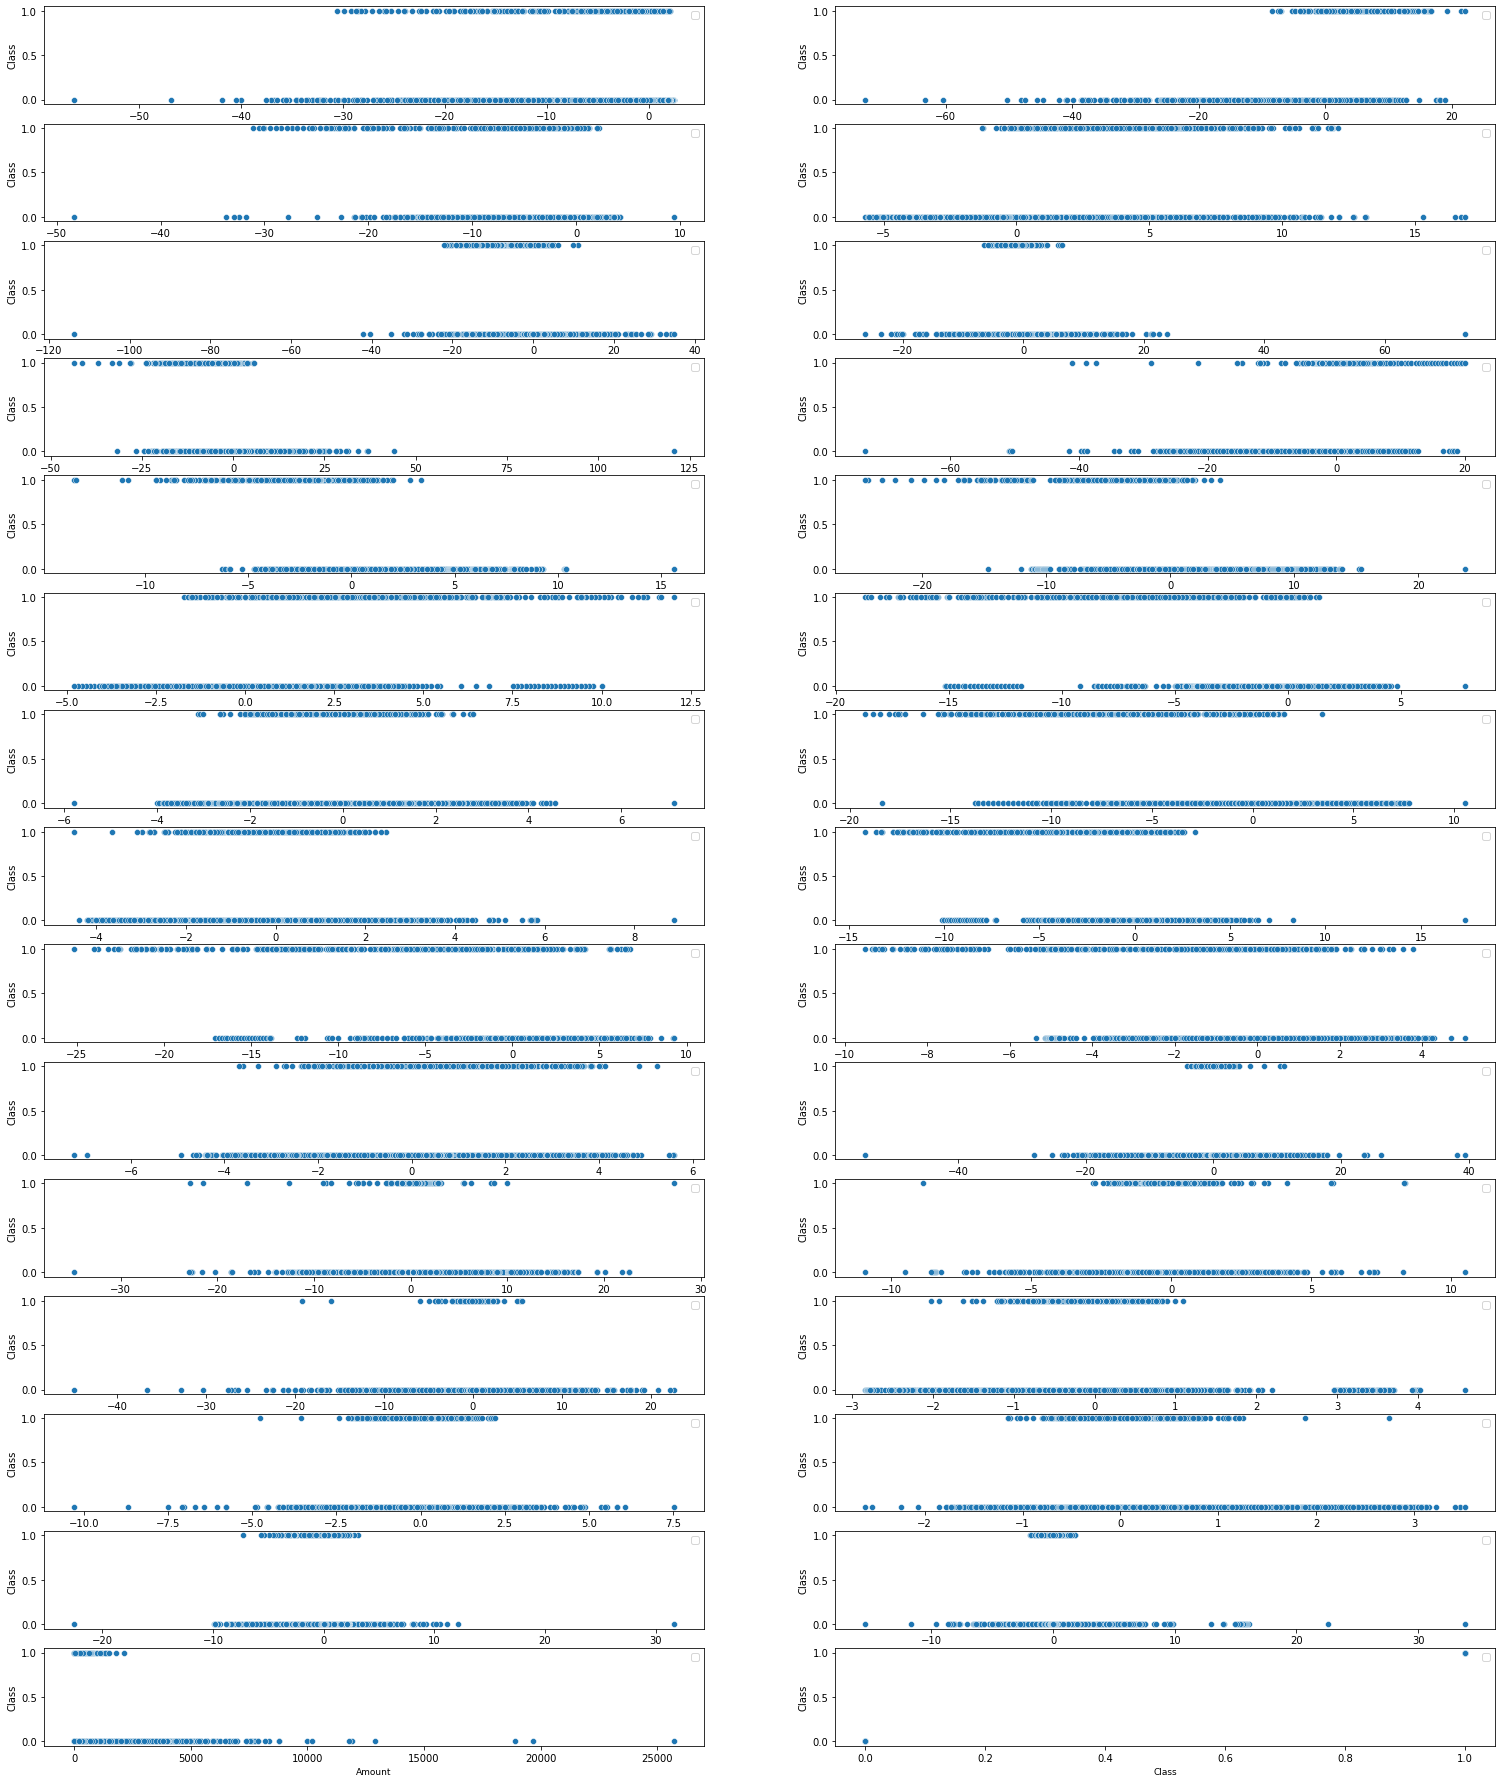

In [42]:
i = 1
plt.figure()
fig, ax = plt.subplots(15, 2,figsize=(26, 32))
for feature in num_col:
    plt.subplot(15, 2,i)
    sns.scatterplot(x=feature, 
                    y=data['Class'], 
                    data=data, 
                    palette='muted')
    #sns.scatterplot(data[feature],color="blue", palette='muted', label='data')
    plt.xlabel(feature, fontsize=9); plt.legend()
    i += 1
plt.show()

## Correlation Matrix

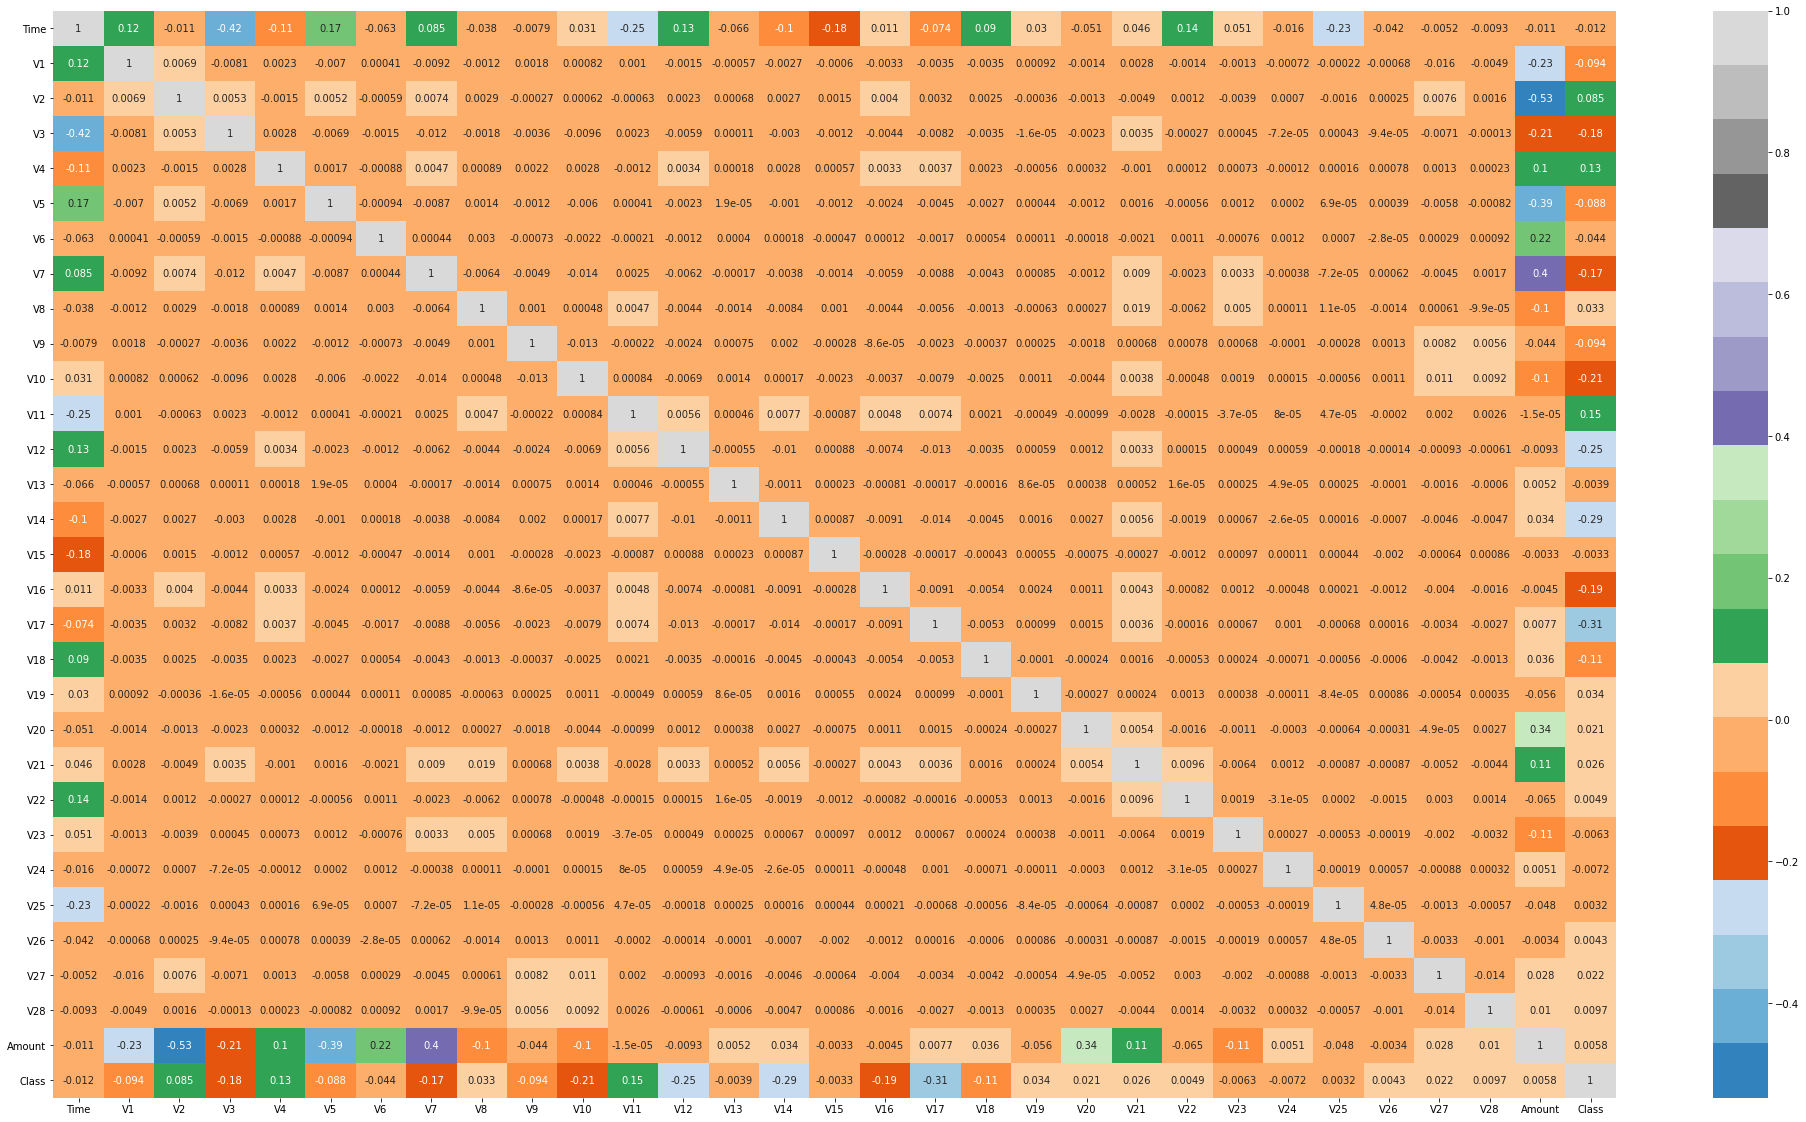

In [43]:
plt.figure(figsize=(35,20))
sns.heatmap(data.corr(),annot=True,cmap="tab20c")
plt.show()

* The heatmap clearly shows which all varible are multicollinear in nature and which variable have high collinearity with the target variable.

## 4. Model Building
### Splitting the Data

In [44]:

X = data.drop('Class', axis = 1)
y = data['Class']

In [45]:
#finding correlation
var = data[data.columns[1:]].corr()['Class'][:]
var.sort_values(ascending=False)

Class     1.000000
V11       0.149067
V4        0.129326
V2        0.084624
V19       0.033631
V8        0.033068
V21       0.026357
V27       0.021892
V20       0.021486
V28       0.009682
Amount    0.005777
V22       0.004887
V26       0.004265
V25       0.003202
V15      -0.003300
V13      -0.003897
V23      -0.006333
V24      -0.007210
V6       -0.043915
V5       -0.087812
V9       -0.094021
V1       -0.094486
V18      -0.105340
V7       -0.172347
V3       -0.182322
V16      -0.187186
V10      -0.206971
V12      -0.250711
V14      -0.293375
V17      -0.313498
Name: Class, dtype: float64

**spliting the data in training set and testing set**

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 1, stratify = y)

In [47]:
X_train.shape, X_test.shape

((226980, 30), (56746, 30))

### Handling Target Imbalance
The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class.We will perform overspampling using imblearn library.



In [48]:
X_train,y_train = RandomOverSampler(random_state=63).fit_resample(X_train, y_train)

### Feature Transformation
#### PowerTransformer

PowerTransformer applies a power transform featurewise to make data more Gaussian-like.

Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

## 5. Building the Model

In [49]:
# Build Model here
LR = make_pipeline(MaxAbsScaler(),QuantileTransformer(),xgb.XGBClassifier())
LR.fit(X_train, y_train)

[23:43:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('quantiletransformer', QuantileTransformer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [50]:
print("Accuracy score {:.2f} %\n".format(LR.score(X_test,y_test)*100))

Accuracy score 99.95 %




### Confusion Matrix
A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.



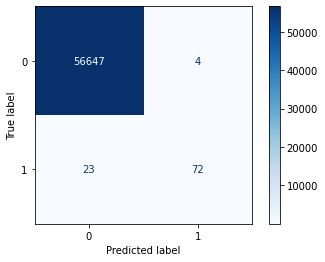

In [51]:
plot_confusion_matrix(LR,X_test,y_test,cmap=plt.cm.Blues)

### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.

**where:**

* Precision:- Accuracy of positive predictions.
* Recall:- Fraction of positives that were correctly identified.
* f1-score:- percent of positive predictions were correct
* support:- Support is the number of actual occurrences of the class in the specified dataset.

In [52]:
print(classification_report(y_test,LR.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.95      0.76      0.84        95

    accuracy                           1.00     56746
   macro avg       0.97      0.88      0.92     56746
weighted avg       1.00      1.00      1.00     56746

